count distributions

In [1]:
import os
import gzip
import sys
import pyBigWig
import numpy as np

In [2]:
tfToBed = {}
tfToBed["cbf1"] = "data/cbf1/old_peaks/1000_around_summits.bed.gz"
tfToBed["fixed_cbf1"] = "data/cbf1/1000_around_summits.bed.gz"
tfToBed["pho4"] = "data/pho4/1000_around_summits.bed.gz"

In [3]:
!zcat {tfToBed["cbf1"]} | wc -l
!zcat {tfToBed["fixed_cbf1"]} | wc -l
!zcat {tfToBed["pho4"]} | wc -l

10449
917
6086


In [4]:
tfToBigWigs = {}
tfToBigWigs["cbf1"] = (pyBigWig.open("data/cbf1/pos_strand.bw"),
                       pyBigWig.open("data/cbf1/neg_strand.bw"))
tfToBigWigs["fixed_cbf1"] = (pyBigWig.open("data/cbf1/pos_strand.bw"),
                             pyBigWig.open("data/cbf1/neg_strand.bw"))
tfToBigWigs["pho4"] = (pyBigWig.open("data/pho4/pos_strand.bw"),
                       pyBigWig.open("data/pho4/neg_strand.bw"))

In [5]:
tfToCounts = {}
tfToCounts["cbf1"] = ([],[])
tfToCounts["fixed_cbf1"] = ([],[])
tfToCounts["pho4"] = ([],[])

In [6]:
for key in tfToBed.keys():
    with gzip.open(tfToBed[key],'rt') as f:
        for line in f:
            chrm, start, end, _ = line.rstrip().split('\t')
            posvals = np.array(tfToBigWigs[key][0].values(chrm, int(start), int(end)))
            where_are_NaNs = np.isnan(posvals)
            posvals[where_are_NaNs] = 0.0
            tfToCounts[key][0].append(np.sum(posvals))
            negvals = np.array(tfToBigWigs[key][1].values(chrm, int(start), int(end)))
            where_are_NaNs = np.isnan(negvals)
            negvals[where_are_NaNs] = 0.0
            tfToCounts[key][1].append(np.sum(np.abs(negvals)))

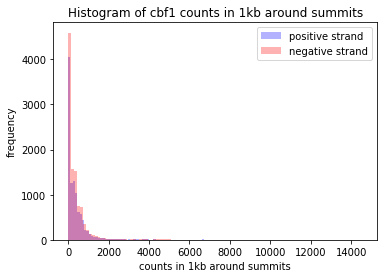

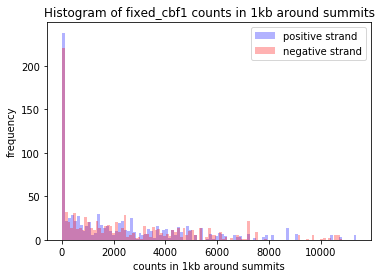

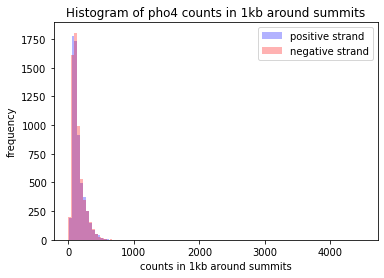

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline  

num_bins = 100
for key in tfToBed.keys():
    plt.hist(tfToCounts[key][0], num_bins, facecolor='blue', alpha=0.3, label='positive strand')    
    plt.hist(tfToCounts[key][1], num_bins, facecolor='red', alpha=0.3, label='negative strand')
    plt.xlabel('counts in 1kb around summits')
    plt.ylabel('frequency')
    plt.title(r'Histogram of '+key+' counts in 1kb around summits')
    plt.legend(loc='upper right')
    plt.subplots_adjust(left=0.15)
    plt.show()

In [8]:
bound = 1000
tfToCounts_bounded = {}
for key in tfToBed.keys():
    tfToCounts_bounded[key] = ([],[])
for key in tfToBed.keys():
    for val0, val1 in zip(tfToCounts[key][0], tfToCounts[key][1]):
        if val0 > bound or val1 > bound:
            continue
        tfToCounts_bounded[key][0].append(val0)
        tfToCounts_bounded[key][1].append(val1)

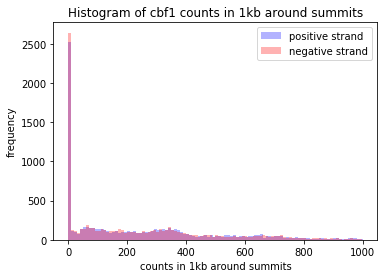

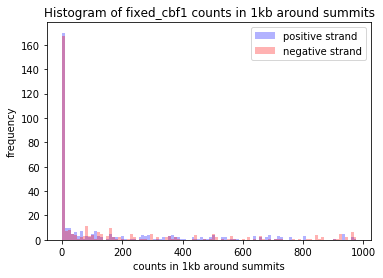

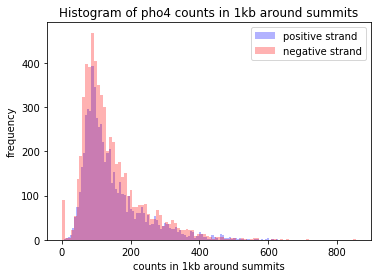

In [9]:
for key in tfToBed.keys():
    plt.hist(tfToCounts_bounded[key][0], num_bins, facecolor='blue', alpha=0.3, label='positive strand')    
    plt.hist(tfToCounts_bounded[key][1], num_bins, facecolor='red', alpha=0.3, label='negative strand')
    plt.xlabel('counts in 1kb around summits')
    plt.ylabel('frequency')
    plt.title(r'Histogram of '+key+' counts in 1kb around summits')
    plt.legend(loc='upper right')
    plt.subplots_adjust(left=0.15)
    plt.show()

Footprinting

In [10]:
fastapath = "sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

In [11]:
chrm_sizes = {}
for chrm in GenomeDict.keys():
    chrm_sizes[chrm]=len(GenomeDict[chrm])

In [12]:
import re

width = 250
posFootprint = {}
negFootprint = {}
motif = "CACGTG"
for key in tfToBed.keys():
    numInstances = 0
    posFootprint[key] = np.zeros((2*width,))
    negFootprint[key] = np.zeros((2*width,))
    with gzip.open(tfToBed[key],'rt') as f:
        for line in f:
            chrm, start, end, _ = line.rstrip().split('\t')
            sequence = GenomeDict[chrm][int(start):int(end)].upper()
            matches = [m.start()+3 for m in re.finditer(motif, sequence)]
            for coord in matches:
                if coord-width<0 or coord+width>=chrm_sizes[chrm]:
                    continue
                numInstances += 1
                posvals = np.array(tfToBigWigs[key][0].values(chrm, coord-width, coord+width))
                where_are_NaNs = np.isnan(posvals)
                posvals[where_are_NaNs] = 0.0
                posFootprint[key] += posvals
                negvals = np.array(tfToBigWigs[key][1].values(chrm, coord-width, coord+width))
                where_are_NaNs = np.isnan(negvals)
                negvals[where_are_NaNs] = 0.0
                negFootprint[key] += negvals
    posFootprint[key] = posFootprint[key]/float(numInstances)
    negFootprint[key] = negFootprint[key]/float(numInstances)

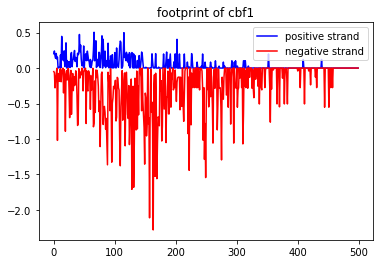

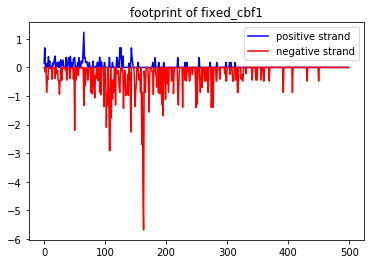

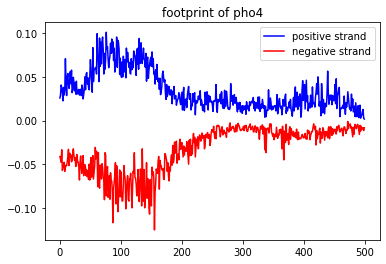

In [13]:
for key in tfToBed.keys():
    t = range(2*width)
    plt.plot(t, posFootprint[key], 'b', label='positive strand') 
    plt.plot(t, negFootprint[key], 'r', label='negative strand')
    plt.title(r'footprint of '+key)
    plt.legend(loc='upper right')
    plt.show()